# House Price  Prediction(Standard Model vs PCA Model)

In [94]:
# Importing all the required packages 

import time
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
pd.pandas.set_option('display.max_columns', None)

### Load Dataset

In [95]:
housedf=pd.read_csv("HousePriceDetails_Cleaned.csv")
housedf.head()

,Price,Bed,Bath,FloorSize,City,ZipCode,LotSize,AgentInfo,PropertyType,CLIndex,popDensity,MAge,MIncome,BPovertyLine,MRent,CrimeIndex,SchoolCount,Restaurants,Groceries,Age,AgeCategory,HOAfees_0
0,1250000.0,4.0,3.0,2209.0,SanJose,95136,6141.0,ML81840754,Single Family Home,149.7,10251.0,36.7,117191.0,7.3,2376.0,277.0,3,51.0,10.0,45.0,MIDDLE AGED,1
1,985000.0,4.0,2.0,1883.0,SanJose,95123,7130.0,ML81841879,Single Family Home,150.0,8331.0,37.8,122947.0,4.9,2608.0,277.0,4,63.0,9.0,53.0,MIDDLE AGED,1
2,925000.0,4.0,2.0,1154.0,SanJose,95127,6838.0,ML81842519,Single Family Home,148.3,5151.0,36.1,103198.0,6.8,2075.0,277.0,1,57.0,12.0,67.0,MIDDLE AGED,1
3,979000.0,4.0,3.0,1743.0,SanJose,95111,6520.0,ML81842454,Single Family Home,148.2,11536.0,35.2,76430.0,11.0,1631.0,277.0,4,46.0,9.0,54.0,MIDDLE AGED,1
4,1148880.0,5.0,2.0,1715.0,SanJose,95136,8800.0,40947217,ResidentialProperty Subtype,149.7,10251.0,36.7,117191.0,7.3,2376.0,277.0,3,41.0,9.0,52.0,MIDDLE AGED,0


In [96]:
#Dropping columns which is not helpful in predicting the House Price
housedf.drop(['ZipCode','City','AgentInfo','PropertyType','AgeCategory'],axis=1,inplace=True)
## Check if any column contain 0 as numerical values
zeroValuedColumns=[]
for column in list(housedf.columns):
    if 0 in housedf[column].unique():
        zeroValuedColumns.append(column)
zeroValuedColumns      

['LotSize', 'CLIndex', 'Age', 'HOAfees_0']

In [97]:
#Age and HOAfees_0 can have 0 as values. SO Handling other two columns

housedf.loc[housedf['LotSize']==0,'LotSize']=housedf['LotSize'].mean()
housedf.loc[housedf['CLIndex']==0,'CLIndex']=housedf['CLIndex'].mean()
housedf.loc[housedf['Age']==0,'Age']=0.5


##### Data Preprocessing before training the  Model

In [98]:
#Defining the features and dependent variable
cat_cols=['HOAfees_0']
target_val=['Price']
numerical_cols=list(set(housedf.columns)-set(cat_cols)-set(target_val))
numerical_cols,cat_cols,target_val
features=numerical_cols+cat_cols
print("Features of the Model",features)

Features of the Model ['Restaurants', 'MAge', 'LotSize', 'SchoolCount', 'popDensity', 'MIncome', 'Bath', 'CrimeIndex', 'FloorSize', 'Groceries', 'BPovertyLine', 'MRent', 'Bed', 'CLIndex', 'Age', 'HOAfees_0']


### Implement PCA  to reduce dimensionality

In [99]:
#Divide the dataset into Training and Testing set.We are selecting some important features which can effect the price based on the
#analysis we did while exploring the relationship between different features and House Price

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(housedf[features],housedf['Price'],test_size=0.1,random_state=0)

In [100]:

#fit scalar on training data
scalar=StandardScaler().fit(X_train[numerical_cols])
#Transform Train and test data
X_train = pd.concat([X_train[['HOAfees_0']].reset_index(drop=True),
                    pd.DataFrame(scalar.transform(X_train[numerical_cols]), columns=numerical_cols)],
                    axis=1)
X_test= pd.concat([X_test[['HOAfees_0']].reset_index(drop=True),
                    pd.DataFrame(scalar.transform(X_test[numerical_cols]), columns=numerical_cols)],
                    axis=1)


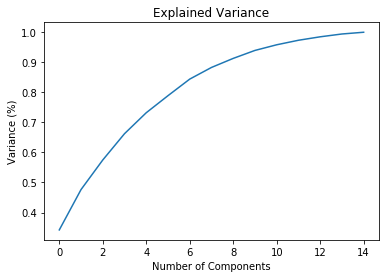

In [101]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(X_train[numerical_cols])
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

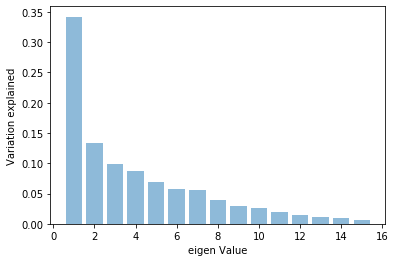

In [62]:
plt.bar(list(range(1,len(numerical_cols)+1)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('No of COmponets)
plt.show()

In [104]:
#We will go with 9 componets as its explaining more than 90 % of the variance in the dataset as evident from the above two plots
pca = PCA(n_components=9)
pca.fit(X_train[numerical_cols])
#print(pca3.components_)
print(pca.explained_variance_ratio_)
X_train_pca = pca.transform(X_train[numerical_cols])
#X_train_pca

[0.3421656  0.13425737 0.09848794 0.08749199 0.0697389  0.05679201
 0.05513379 0.03877895 0.03011818]


In [105]:
X_train_pca = pd.DataFrame(data = X_train_pca
             , columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])

In [106]:
#Transform test data as well

X_test_pca = pca.transform(X_test[numerical_cols])
X_test_pca = pd.DataFrame(data = X_test_pca
             , columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])


##### Training the model  after applying PCA

In [110]:

from sklearn.linear_model import LinearRegression

pca_reg = LinearRegression()
pca_reg.fit(X_train_pca, y_train)

# Create Y Predictions
y_predict = pca_reg.predict(X_test_pca)

rmse = math.sqrt(mean_squared_error(y_test, y_predict))
print("RMSE of PCA Model",round(rmse,2))

RMSE of PCA Model 773193.24


In [111]:
std_reg = LinearRegression()
std_reg.fit(X_train, y_train)

# Create Y Predictions
y_predict = std_reg.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_predict))
print("RMSE of std Model",round(rmse,2))

RMSE of std Model 846220.98


### With PCA the accuracy metrics of the model has been considerably improved!!!